<a href="https://colab.research.google.com/github/rbbh/Forecasting-Time-Series-with-Algorithm-Ensembling/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
from google.colab import files
uploaded = files.upload()

Saving coloradoRiver.txt to coloradoRiver.txt


In [0]:
import io
import pandas as pd

# Un-comment the line for the data base that
# you want to predict

#data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['carsales.txt']))
data = pd.read_csv(io.BytesIO(uploaded['coloradoRiver.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['accidentalDeathUSA.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['electric.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['gas.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['lakeerie.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['milk.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['redwine.txt']))

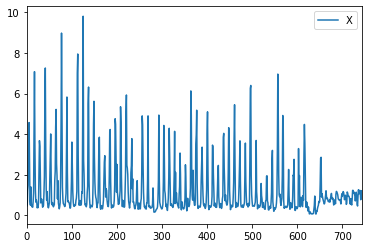

In [4]:
data.plot()


In [5]:
len(data)

744

In [0]:
#Normalizing the data
data_n = data.copy()
data_n = data/data.max()

In [7]:
# TODO: Create function for the Lag used for the prediction
# We will use 12 for the lag dimension if the series repeats 
# itself annually, 3 if it is trimestrial etc.

# Note: For the "ONS" data base, make "dimensions" = 3
# NOTE: For the "Milk" data base, make "dimensions" = 24

dimensions = 12
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

            X         X         X  ...         X         X         X
0    0.046891       NaN       NaN  ...       NaN       NaN       NaN
1    0.054027  0.046891       NaN  ...       NaN       NaN       NaN
2    0.126402  0.054027  0.046891  ...       NaN       NaN       NaN
3    0.150866  0.126402  0.054027  ...       NaN       NaN       NaN
4    0.376147  0.150866  0.126402  ...       NaN       NaN       NaN
..        ...       ...       ...  ...       ...       ...       ...
739  0.125382  0.113150  0.107034  ...  0.072375  0.096840  0.109072
740  0.116208  0.125382  0.113150  ...  0.094801  0.072375  0.096840
741  0.078491  0.116208  0.125382  ...  0.116208  0.094801  0.072375
742  0.083588  0.078491  0.116208  ...  0.099898  0.116208  0.094801
743  0.123344  0.083588  0.078491  ...  0.055046  0.099898  0.116208

[744 rows x 13 columns]


In [8]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))


146
147
439


In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing particles' positions randomly, inside
    # the search space
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles' parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize  
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    best_iter = np.zeros(iterations)

    # Initializing regression variables
    p_best_RGS = np.empty((n_particles), dtype = object);
    g_best_RGS = sys.maxsize

    

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # To un-normalize the data:
          # Multiply the values by
          # data.to_numpy().max()

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point, for that particle,
          # is less than its personal best point,
          # replace personal best
          if(mse < p_best_val[j]):   # mse < p_best_val[j]
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = mse
              
              p_best_RGS[j] = rgs
                           

              # The value below represents the current search coordinates for
              # the particle's current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]

              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()

              # Group best regressor:
              # the combination of C, Epsilon and Gamma
              # that computes the best fitting curve
              g_best_RGS = p_best_RGS[aux]

        
          rand1 = np.random.random()
          rand2 = np.random.random()

          # The variable below influences directly the particle's velocity.
          # It can either make it smaller or bigger. 
          w = inertia

          # The equation below represents Particle's velocity, which is
          # the rate of change in its position
          v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

          # Change in the Particle's position 
          c[j] = c[j] + v[j]

          # Below is a series of conditions that stop the particles from
          # leaving the search space
          if(c[j][2] < min_g):
            c[j][2] = min_g
          if(c[j][2] > max_g):
            c[j][2] = max_g
          if(c[j][1] < min_e):
            c[j][1] = min_e
          if(c[j][1] > max_e):
            c[j][1] = max_e
          if(c[j][0] < min_c):
            c[j][0] = min_c
          if(c[j][0] > max_c):
            c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Best Regressor:\n')
    print(g_best_RGS)
    print('\n')
    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = g_best_RGS.predict(X_test)

    
    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [0]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [0]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

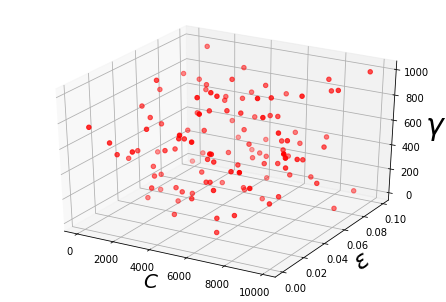





Best value iteration # 0 = 0.007992

Best value iteration # 1 = 0.006630

Best value iteration # 2 = 0.006626

Best value iteration # 3 = 0.006532

Best value iteration # 4 = 0.006532

Best value iteration # 5 = 0.006480

Best value iteration # 6 = 0.006480

Best value iteration # 7 = 0.006480

Best value iteration # 8 = 0.006480

Best value iteration # 9 = 0.006480

Best value iteration # 10 = 0.006479

Best value iteration # 11 = 0.006479

Best value iteration # 12 = 0.006479

Best value iteration # 13 = 0.006479

Best value iteration # 14 = 0.006479

Best value iteration # 15 = 0.006479

Best value iteration # 16 = 0.006479

Best value iteration # 17 = 0.006479

Best value iteration # 18 = 0.006479

Best value iteration # 19 = 0.006479

Best value iteration # 20 = 0.006479

Best value iteration # 21 = 0.006479

Best value iteration # 22 = 0.006479

Best value iteration # 23 = 0.006479

Best value iteration # 24 = 0.006479

Group Best configuration found: 
[1.00000000e+04 3.75968

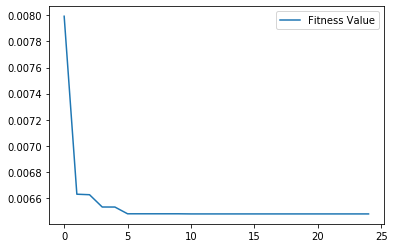

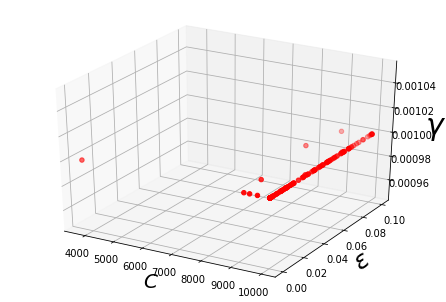





Predictions with the Population Best Value found:



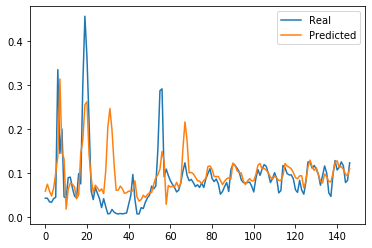





Mean Squared Error for the Test Set:	 0.003002




Predictions Average:	 0.096271




Predictions Median:	 0.089314






In [0]:
pso(120, 25, 3, 1)

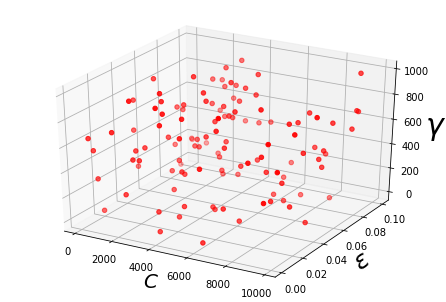





Best value iteration # 0 = 0.007879

Best value iteration # 1 = 0.006871

Best value iteration # 2 = 0.005624

Best value iteration # 3 = 0.005624

Best value iteration # 4 = 0.005624

Best value iteration # 5 = 0.005624

Best value iteration # 6 = 0.005624

Best value iteration # 7 = 0.005624

Best value iteration # 8 = 0.005624

Best value iteration # 9 = 0.005549

Best value iteration # 10 = 0.005317

Best value iteration # 11 = 0.005317

Best value iteration # 12 = 0.005317

Best value iteration # 13 = 0.005317

Best value iteration # 14 = 0.005312

Best value iteration # 15 = 0.005285

Best value iteration # 16 = 0.005285

Best value iteration # 17 = 0.005285

Best value iteration # 18 = 0.005208

Best value iteration # 19 = 0.005208

Best value iteration # 20 = 0.005208

Best value iteration # 21 = 0.005208

Best value iteration # 22 = 0.005208

Best value iteration # 23 = 0.005135

Best value iteration # 24 = 0.005135

Group Best configuration found: 
[2.34941645e+02 5.50447

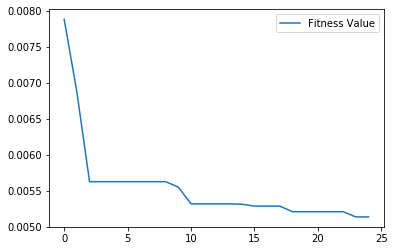

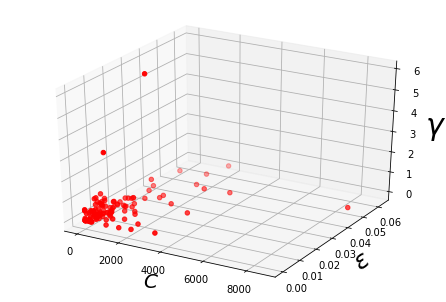





Predictions with the Population Best Value found:



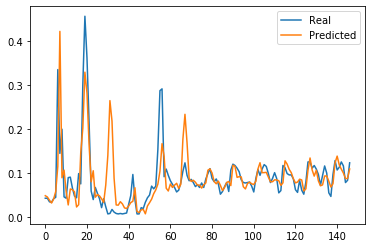





Mean Squared Error for the Test Set:	 0.002994




Predictions Average:	 0.087060




Predictions Median:	 0.079182






In [13]:
pso(120, 25, 3, 0.8)

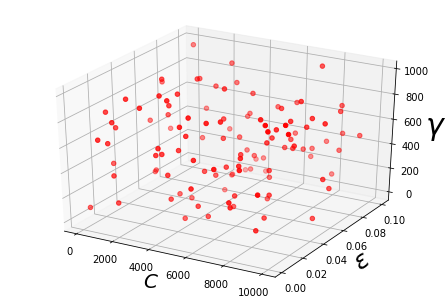





Best value iteration # 0 = 0.010417

Best value iteration # 1 = 0.006543

Best value iteration # 2 = 0.006482

Best value iteration # 3 = 0.006482

Best value iteration # 4 = 0.006482

Best value iteration # 5 = 0.006479

Best value iteration # 6 = 0.006475

Best value iteration # 7 = 0.006475

Best value iteration # 8 = 0.006475

Best value iteration # 9 = 0.006475

Best value iteration # 10 = 0.006475

Best value iteration # 11 = 0.006475

Best value iteration # 12 = 0.006475

Best value iteration # 13 = 0.006475

Best value iteration # 14 = 0.006475

Best value iteration # 15 = 0.006475

Best value iteration # 16 = 0.006475

Best value iteration # 17 = 0.006475

Best value iteration # 18 = 0.006475

Best value iteration # 19 = 0.006475

Best value iteration # 20 = 0.006475

Best value iteration # 21 = 0.006475

Best value iteration # 22 = 0.006475

Best value iteration # 23 = 0.006475

Best value iteration # 24 = 0.006475

Group Best configuration found: 
[1.00000000e+04 3.80379

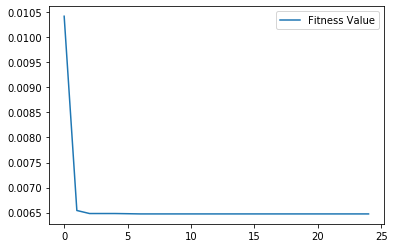

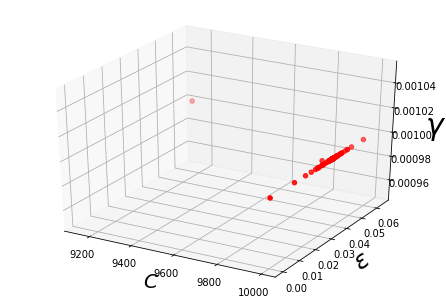





Predictions with the Population Best Value found:



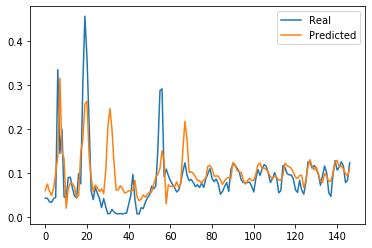





Mean Squared Error for the Test Set:	 0.003013




Predictions Average:	 0.097144




Predictions Median:	 0.090145






In [14]:
pso(120, 25, 3, 0.6)

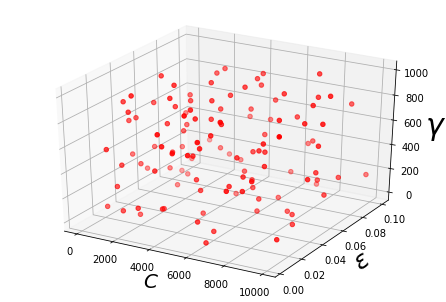





Best value iteration # 0 = 0.007979

Best value iteration # 1 = 0.006614

Best value iteration # 2 = 0.006553

Best value iteration # 3 = 0.006498

Best value iteration # 4 = 0.006479

Best value iteration # 5 = 0.006479

Best value iteration # 6 = 0.006478

Best value iteration # 7 = 0.006478

Best value iteration # 8 = 0.006478

Best value iteration # 9 = 0.006476

Best value iteration # 10 = 0.006476

Best value iteration # 11 = 0.006476

Best value iteration # 12 = 0.006476

Best value iteration # 13 = 0.006475

Best value iteration # 14 = 0.006475

Best value iteration # 15 = 0.006475

Best value iteration # 16 = 0.006475

Best value iteration # 17 = 0.006475

Best value iteration # 18 = 0.006475

Best value iteration # 19 = 0.006475

Best value iteration # 20 = 0.006475

Best value iteration # 21 = 0.006475

Best value iteration # 22 = 0.006475

Best value iteration # 23 = 0.006475

Best value iteration # 24 = 0.006474

Group Best configuration found: 
[1.00000000e+04 3.75219

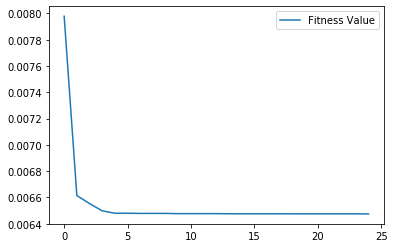

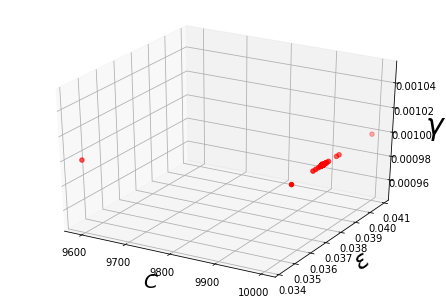





Predictions with the Population Best Value found:



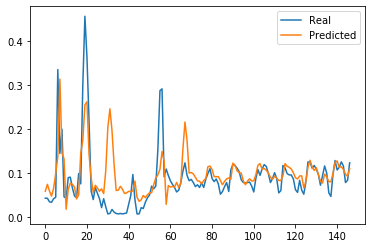





Mean Squared Error for the Test Set:	 0.002992




Predictions Average:	 0.095994




Predictions Median:	 0.088899






In [15]:
pso(120, 25, 3, 0.2)